In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR']='cuda_async_malloc'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.00'

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path='/kaggle/input/final-capstone-data/combined /training'
test_path='/kaggle/input/final-capstone-data/combined /testing'
val_path='/kaggle/input/final-capstone-data/combined /validation'

2025-09-08 04:28:44.310078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757305724.477087      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757305724.527478      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_datagen=ImageDataGenerator(
    rescale=1./255,#Normalize the pixel values to [0,255]
    horizontal_flip=True,# Randomly flips images horizontally—great for symmetry-based features
    width_shift_range=0.2,#Shifts images horizontally by up to 20% of the width
    height_shift_range=0.2,# Shifts images vertically by up to 20% of the height
    shear_range=0.2,# Applies shear transformations-slanting the image
    zoom_range=0.2, # Randomly zooms in on images by up to 20%
    rotation_range=30,# Rotates images randomly within a range of ±30 degrees
    fill_mode='nearest'# Fills in pixels that are created during transformations using the nearest pixel values
)

In [4]:
val_test_datagen=ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_data=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    class_mode='categorical'
)

Found 41264 images belonging to 8 classes.


In [6]:
test_data=val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 10893 images belonging to 8 classes.


In [7]:
val_data=val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 5708 images belonging to 8 classes.


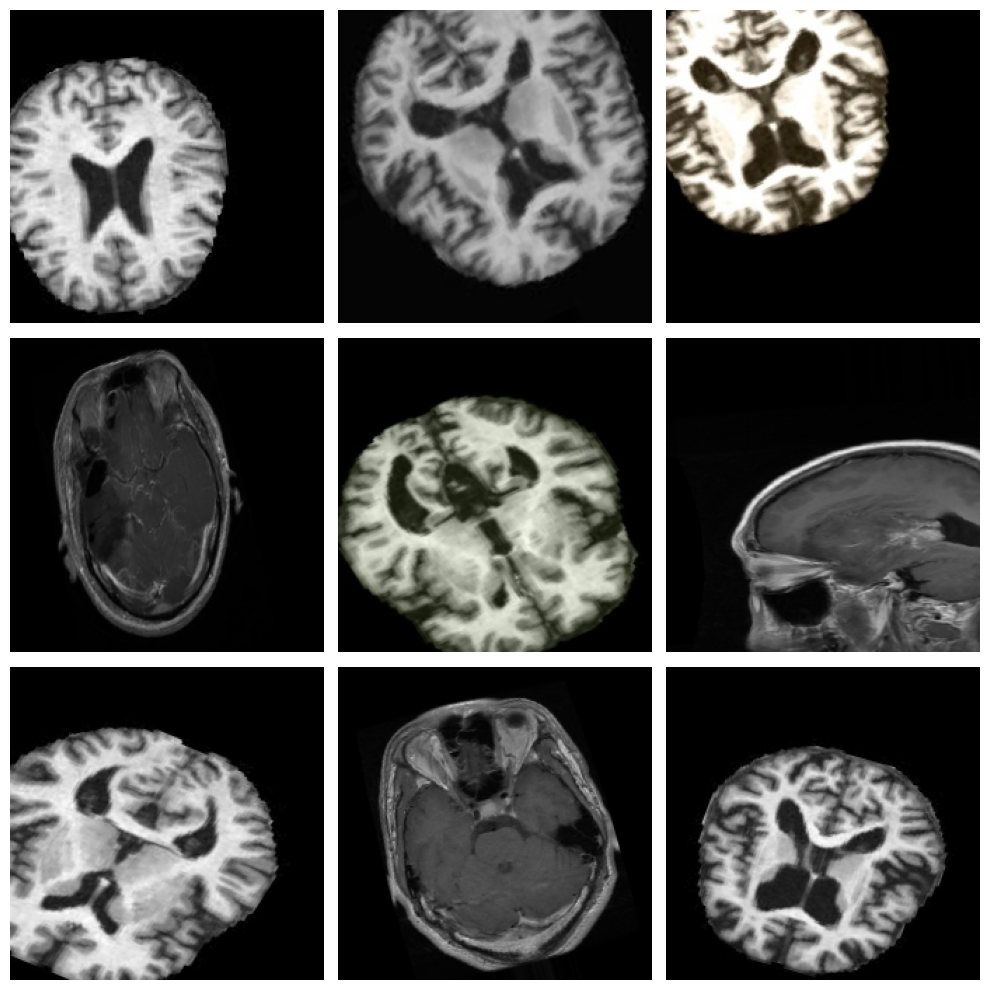

In [8]:
import matplotlib.pyplot as plt
sample_images,sample_labels=next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
def count_images_per_class(generator,split_name=""):
    class_labels=list(generator.class_indices.keys())  
    counts=np.bincount(generator.classes)  
    print(f"\n{split_name} set distribution:")
    for label,count in zip(class_labels,counts):
        print(f"{label}:{count} images")
    print(f"Total:{sum(counts)} images")
count_images_per_class(train_data,"Training")
count_images_per_class(val_data,"Validation")
count_images_per_class(test_data,"Testing")


Training set distribution:
MildDemented:7000 images
ModerateDemented:7000 images
NonDemented:8960 images
VeryMildDemented:7839 images
glioma:3121 images
meningioma:2880 images
notumor:2696 images
pituitary:1768 images
Total:41264 images

Validation set distribution:
MildDemented:1000 images
ModerateDemented:1000 images
NonDemented:1280 images
VeryMildDemented:1121 images
glioma:417 images
meningioma:385 images
notumor:360 images
pituitary:145 images
Total:5708 images

Testing set distribution:
MildDemented:2000 images
ModerateDemented:2000 images
NonDemented:2560 images
VeryMildDemented:2240 images
glioma:624 images
meningioma:576 images
notumor:539 images
pituitary:354 images
Total:10893 images


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(train_data.classes),y=train_data.classes)
class_weights_dict=dict(enumerate(class_weights))

In [11]:
print(class_weights_dict)

{0: 0.7368571428571429, 1: 0.7368571428571429, 2: 0.5756696428571428, 3: 0.6579920908279118, 4: 1.6526754245434156, 5: 1.7909722222222222, 6: 1.9132047477744807, 7: 2.917420814479638}


In [12]:
from tensorflow.keras import layers,models,Model,Input
from tensorflow.keras.applications import DenseNet201
base_model=DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

I0000 00:00:1757305783.250922      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
base_model.trainable=False

In [14]:
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=1024,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=512,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.25),
    layers.Dense(units=256,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.2),
    layers.Dense(units=128,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.15),
    layers.Dense(units=64,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.1),
    layers.Dense(units=8,activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,994,824 (80.09 MB)

 Trainable params: 2,668,872 (10.18 MB)

 Non-trainable params: 18,325,952 (69.91 MB)

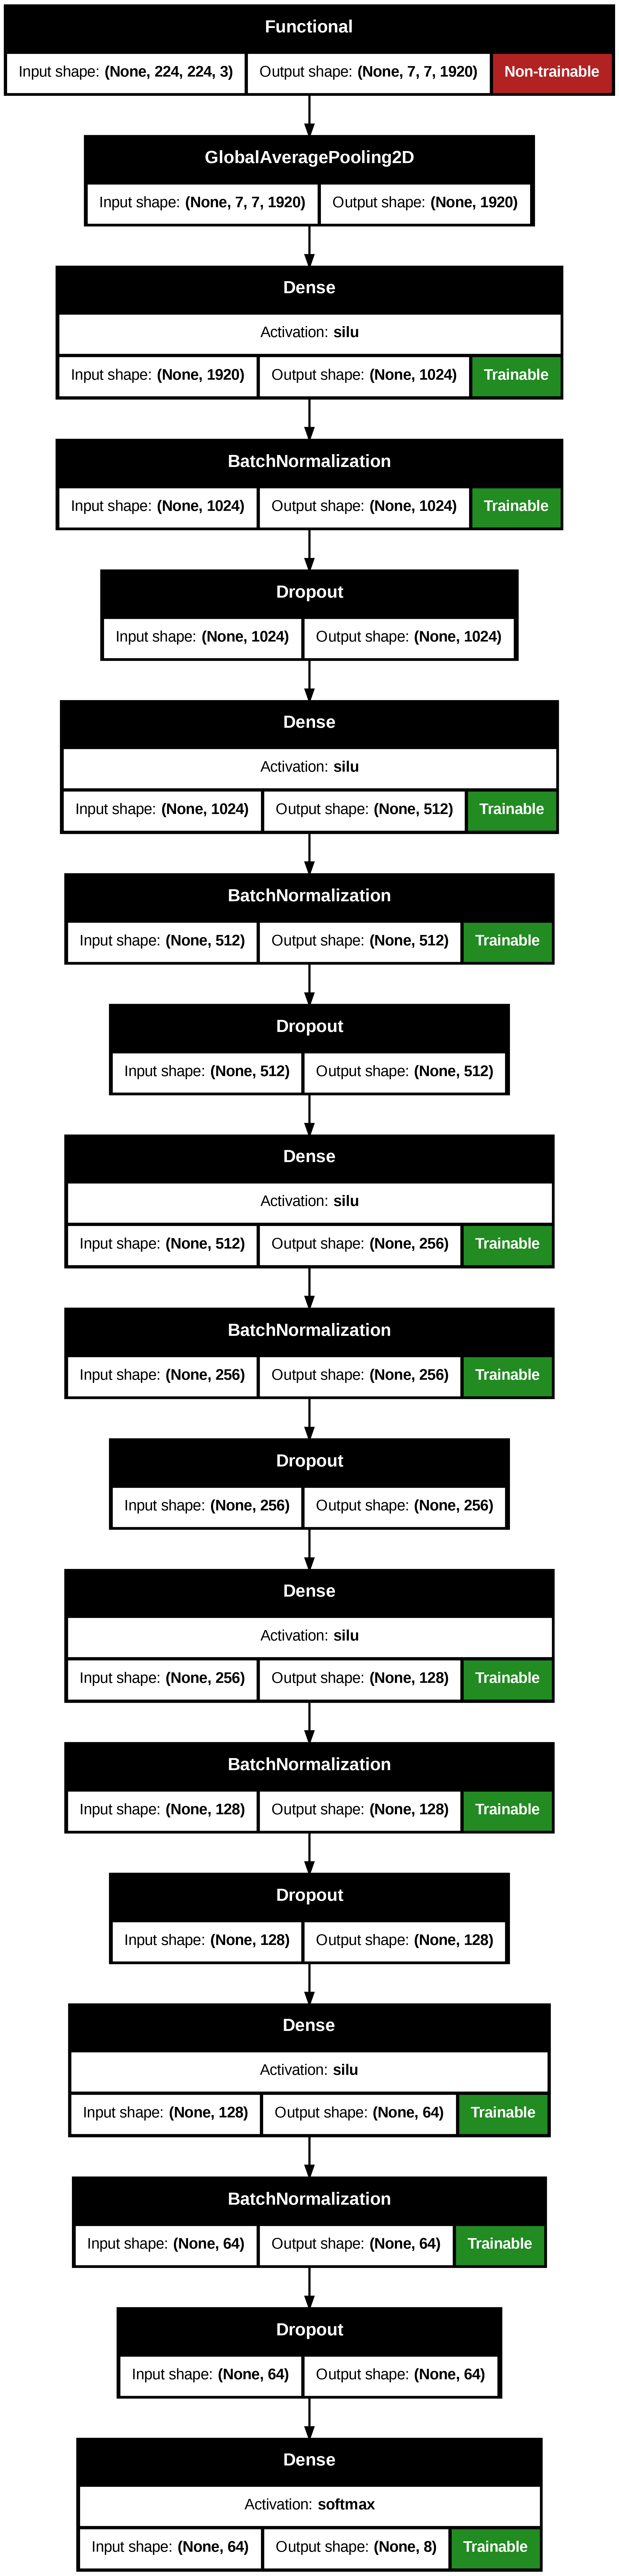

In [15]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    dpi=300,
    show_layer_activations=True,
    show_trainable=True
)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC,TopKCategoricalAccuracy
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=5,name='top5'),AUC(name='auc')])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper=EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)

In [18]:
history1=model.fit(train_data,validation_data=val_data,epochs=50,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1757305848.676522     121 service.cc:148] XLA service 0x7b27ec002ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757305848.677417     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757305853.863349     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1290 ━━━━━━━━━━━━━━━━━━━━ 1:47 83ms/step - accuracy: 0.1172 - auc: 0.5347 - loss: 2.8580 - top5: 0.6484   

I0000 00:00:1757305877.795776     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 712s 501ms/step - accuracy: 0.4363 - auc: 0.8176 - loss: 1.4349 - top5: 0.9043 - val_accuracy: 0.7039 - val_auc: 0.9631 - val_loss: 0.7086 - val_top5: 0.9996
Epoch 2/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 480s 372ms/step - accuracy: 0.6459 - auc: 0.9455 - loss: 0.7498 - top5: 0.9951 - val_accuracy: 0.7071 - val_auc: 0.9661 - val_loss: 0.6611 - val_top5: 1.0000
Epoch 3/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 488s 379ms/step - accuracy: 0.6831 - auc: 0.9586 - loss: 0.6268 - top5: 0.9982 - val_accuracy: 0.7458 - val_auc: 0.9739 - val_loss: 0.5734 - val_top5: 1.0000
Epoch 4/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 480s 372ms/step - accuracy: 0.7121 - auc: 0.9651 - loss: 0.5599 - top5: 0.9986 - val_accuracy: 0.7467 - val_auc: 0.9723 - val_loss: 0.5927 - val_top5: 1.0000
Epoch 5/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 489s 379ms/step - accuracy: 0.7271 - auc: 0.9692 - loss: 0.5208 - top5: 0.9992 - val_accuracy: 0.7679 - val_auc: 0.9773 - val_loss: 0.5392 - val_top5: 1.0000
Epoch 6/50


In [19]:
base_model.trainable=True

In [20]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=5,name='top5'),AUC(name='auc')])

In [21]:
history2=model.fit(train_data,validation_data=val_data,epochs=25,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

Epoch 1/25


2025-09-08 11:23:22.200326: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_2240374__.93335] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-09-08 11:23:28.815640: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m6.615488508s

********************************
[Compiling module a_inference_one_step_on_data_2240374__.93335] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1228s 628ms/step - accuracy: 0.6213 - auc: 0.9167 - loss: 1.0871 - top5: 0.9853 - val_accuracy: 0.7954 - val_auc: 0.9808 - val_loss: 0.4942 - val_top5: 1.0000
Epoch 2/25
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 481s 373ms/step - accuracy: 0.7832 - auc: 0.9777 - loss: 0.4136 - top5: 0.9994 - val_accuracy: 0.8695 - val_auc: 0.9915 - val_loss: 0.3180 - val_top5: 1.0000
Epoch 3/25
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 481s 373ms/step - accuracy: 0.8426 - auc: 0.9885 - loss: 0.2749 - top5: 0.9999 - val_accuracy: 0.9156 - val_auc: 0.9962 - val_loss: 0.2183 - val_top5: 1.0000
Epoch 4/25
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 491s 380ms/step - accuracy: 0.8803 - auc: 0.9925 - loss: 0.2175 - top5: 1.0000 - val_accuracy: 0.9340 - val_auc: 0.9974 - val_loss: 0.1753 - val_top5: 1.0000
Epoch 5/25
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 489s 379ms/step - accuracy: 0.9062 - auc: 0.9950 - loss: 0.1756 - top5: 1.0000 - val_accuracy: 0.9522 - val_auc: 0.9986 - val_loss: 0.1307 - val_top5: 1.0000
Epoch 6/25

In [22]:
test_loss,test_accuracy,test_top5,test_auc=model.evaluate(test_data,verbose=1)
print(f"\nTest Loss:{test_loss:.4f}")
print(f"Test Accuracy:{test_accuracy*100:.4f}%")
print(f"Test Top-5 Accuracy:{test_top5*100:.4f}%")
print(f"Test AUC:{test_auc*100:.4f}%")

341/341 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0036 - top5: 1.0000

Test Loss:0.0079
Test Accuracy:99.7521%
Test Top-5 Accuracy:100.0000%
Test AUC:99.9943%


In [23]:
val_loss,val_accuracy,val_top5,val_auc=model.evaluate(val_data,verbose=1)
print(f"\nValidation Loss:{val_loss:.4f}")
print(f"Validation Accuracy:{val_accuracy*100:.4f}%")
print(f"Validation Top-5 Accuracy:{val_top5*100:.4f}%")
print(f"Validation AUC:{val_auc*100:.4f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9994 - auc: 1.0000 - loss: 0.0034 - top5: 1.0000

Validation Loss:0.0055
Validation Accuracy:99.8774%
Validation Top-5 Accuracy:100.0000%
Validation AUC:99.9898%


In [24]:
import numpy as np
y_pred=model.predict(test_data)
y_pred_class=np.argmax(y_pred,axis=1)
y_true=test_data.classes

341/341 ━━━━━━━━━━━━━━━━━━━━ 69s 142ms/step


In [25]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

accuracy=accuracy_score(y_true,y_pred_class)
precision=precision_score(y_true,y_pred_class,average='weighted',zero_division=1)
recall=recall_score(y_true,y_pred_class,average='weighted')
f1=f1_score(y_true,y_pred_class,average='weighted',zero_division=1)

print("\nPerformance Metrics Breakdown:")
print(f"Accuracy:{accuracy*100:.4f}%")
print(f"Precision:{precision*100:.4f}%")
print(f"Recall:{recall*100:.4f}%")
print(f"F1-Score:{f1*100:.4f}%")


Performance Metrics Breakdown:
Accuracy:99.7521%
Precision:99.7526%
Recall:99.7521%
F1-Score:99.7522%


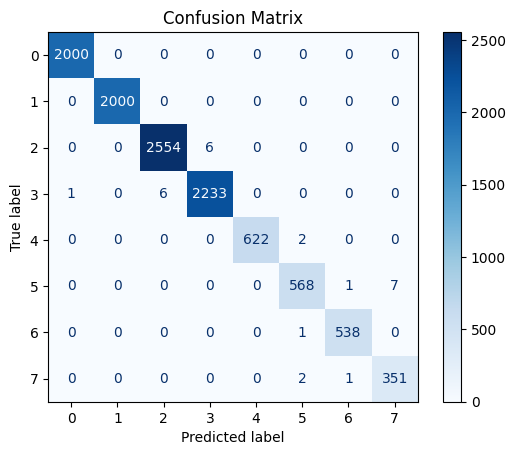

In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm=confusion_matrix(y_true,y_pred_class)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [27]:
class_labels=list(val_data.class_indices.keys())

In [28]:
print("Classification Report:")
print(classification_report(y_true,y_pred_class,target_names=class_labels,zero_division=1))

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      2000
ModerateDemented       1.00      1.00      1.00      2000
     NonDemented       1.00      1.00      1.00      2560
VeryMildDemented       1.00      1.00      1.00      2240
          glioma       1.00      1.00      1.00       624
      meningioma       0.99      0.99      0.99       576
         notumor       1.00      1.00      1.00       539
       pituitary       0.98      0.99      0.99       354

        accuracy                           1.00     10893
       macro avg       1.00      1.00      1.00     10893
    weighted avg       1.00      1.00      1.00     10893



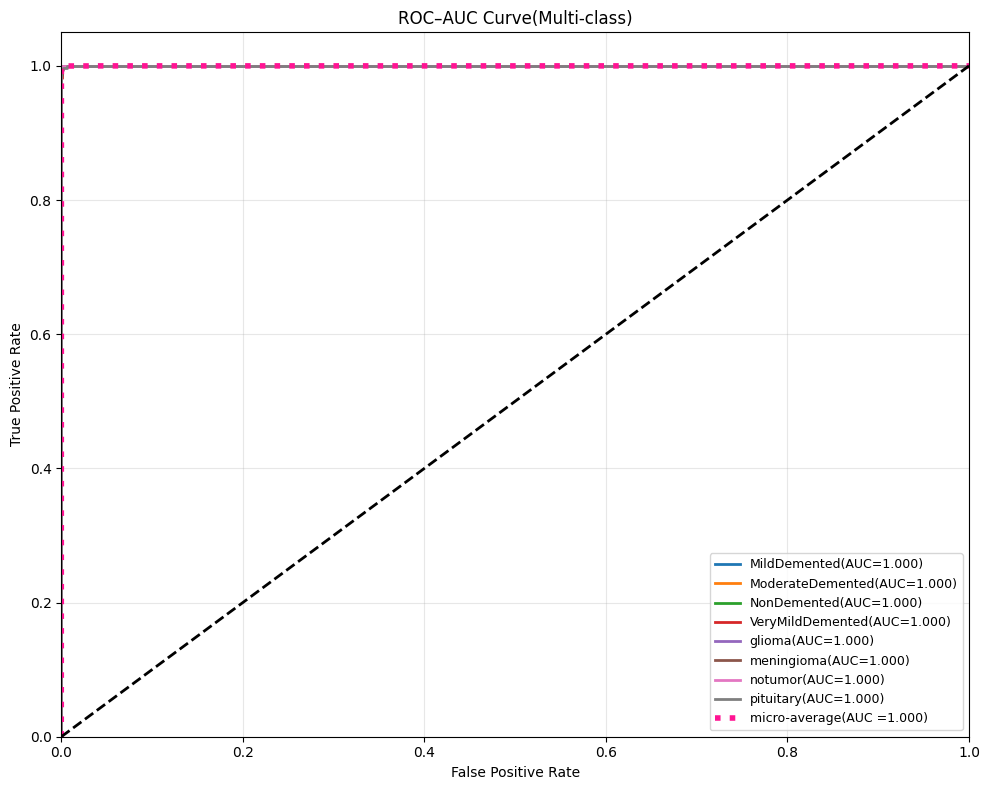


Macro-average ROC-AUC:1.0000
Weighted-average ROC-AUC:1.0000


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.preprocessing import label_binarize

num_classes=len(test_data.class_indices)
y_true_bin=label_binarize(y_true,classes=list(range(num_classes)))

fpr={}
tpr={}
roc_auc={}

for i in range(num_classes):
    fpr[i],tpr[i],_=roc_curve(y_true_bin[:,i],y_pred[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])

fpr["micro"],tpr["micro"],_=roc_curve(y_true_bin.ravel(),y_pred.ravel())
roc_auc["micro"]=auc(fpr["micro"],tpr["micro"])
plt.figure(figsize=(10,8))

for i,class_name in enumerate(test_data.class_indices.keys()):
    plt.plot(fpr[i],tpr[i],lw=2,
             label=f"{class_name}(AUC={roc_auc[i]:.3f})")

plt.plot(fpr["micro"],tpr["micro"],
         label=f"micro-average(AUC ={roc_auc['micro']:.3f})",
         color="deeppink",linestyle=":",linewidth=4)


plt.plot([0,1],[0,1],"k--",lw=2)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve(Multi-class)")
plt.legend(loc="lower right",fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_auc_multiclass.png",dpi=300)
plt.show()

macro_roc_auc=roc_auc_score(y_true_bin,y_pred,average="macro",multi_class="ovr")
weighted_roc_auc=roc_auc_score(y_true_bin,y_pred,average="weighted",multi_class="ovr")
print(f"\nMacro-average ROC-AUC:{macro_roc_auc:.4f}")
print(f"Weighted-average ROC-AUC:{weighted_roc_auc:.4f}")

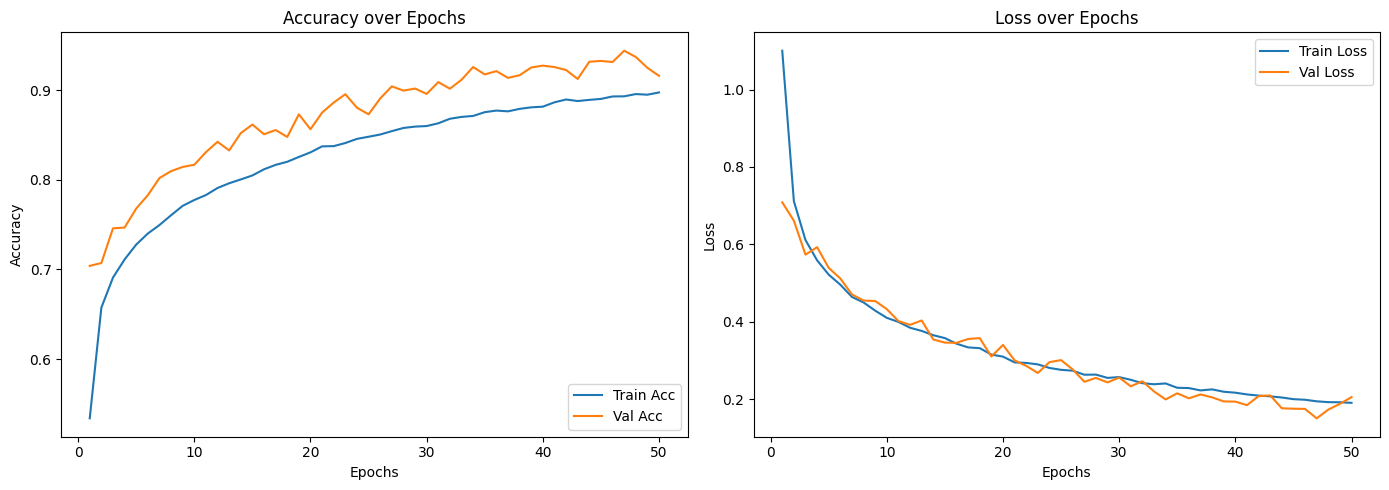

In [30]:
import matplotlib.pyplot as plt

acc1=history1.history['accuracy']
val_acc1=history1.history['val_accuracy']
loss1=history1.history['loss']
val_loss1=history1.history['val_loss']
epochs_range1=range(1,len(acc1)+1)


plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_range1,acc1,label='Train Acc')
plt.plot(epochs_range1,val_acc1,label='Val Acc')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(epochs_range1,loss1,label='Train Loss')
plt.plot(epochs_range1,val_loss1,label='Val Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss over Epochs')

plt.tight_layout()
plt.savefig("training_curves_feature_extraction.png",dpi=300)  
plt.show()

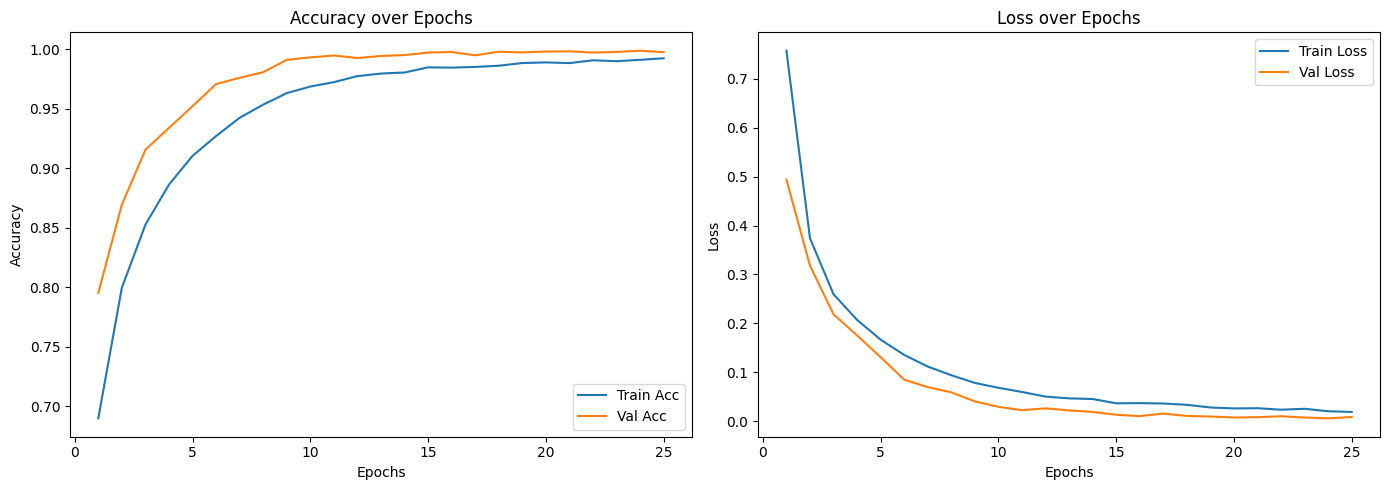

In [31]:
import matplotlib.pyplot as plt

acc2=history2.history['accuracy']
val_acc2=history2.history['val_accuracy']
loss2=history2.history['loss']
val_loss2=history2.history['val_loss']
epochs_range2=range(1,len(acc2)+1)


plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_range2,acc2,label='Train Acc')
plt.plot(epochs_range2,val_acc2,label='Val Acc')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(epochs_range2,loss2,label='Train Loss')
plt.plot(epochs_range2,val_loss2,label='Val Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss over Epochs')

plt.tight_layout()
plt.savefig("training_curves_fine_tuning.png",dpi=300)  
plt.show()

In [32]:
from tensorflow.keras.models import save_model
save_model(model,'DenseNET201_WEIGHTS_BIASES.keras')

In [33]:
import zipfile
import os
from IPython.display import FileLink
zip_file = 'model_weights.zip'
with zipfile.ZipFile(zip_file, 'w') as zipf:
    zipf.write('/kaggle/working/DenseNET201_WEIGHTS_BIASES.keras')
FileLink(zip_file)

/kaggle/working/model_weights.zip